### `Homework4: deployment`


## Question 1

* Install Pipenv
* What's the version of pipenv you installed?
* Use `--version` to find out

In [1]:
# To install Pipenv and check its version
pip install pipenv

In [ ]:
pipenv --version

pipenv, version 2024.2.0

## Question 2

* Use Pipenv to install Scikit-Learn version 1.5.2
* What's the first hash for scikit-learn you get in Pipfile.lock?

> **Note**: you should create an empty folder for homework and do it there. 

In [ ]:
pipenv install scikit-learn==1.5.2

```
"scikit-learn": {
            "hashes": [
                "sha256:03b6158efa3faaf1feea3faa884c840ebd61b6484167c711548fce208ea09445",

```

## Models

We've prepared a dictionary vectorizer and a model.

They were trained (roughly) using this code:

```python
features = ['job', 'duration', 'poutcome']
dicts = df[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X = dv.fit_transform(dicts)

model = LogisticRegression().fit(X, y)
```

> **Note**: You don't need to train the model. This code is just for your reference.

And then saved with Pickle. Download them:

* [DictVectorizer](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/cohorts/2024/05-deployment/homework/dv.bin?raw=true)
* [LogisticRegression](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/cohorts/2024/05-deployment/homework/model1.bin?raw=true)

With `wget`:

```bash
PREFIX=https://raw.githubusercontent.com/DataTalksClub/machine-learning-zoomcamp/master/cohorts/2024/05-deployment/homework
wget $PREFIX/model1.bin
wget $PREFIX/dv.bin
```


## Question 3

Let's use these models!

* Write a script for loading these models with pickle
* Score this client:

```json
{"job": "management", "duration": 400, "poutcome": "success"}
```

What's the probability that this client will get a subscription? 

* 0.359
* 0.559
* 0.759
* 0.959

If you're getting errors when unpickling the files, check their checksum:

```bash
$ md5sum model1.bin dv.bin
3d8bb28974e55edefa000fe38fd3ed12  model1.bin
7d37616e00aa80f2152b8b0511fc2dff  dv.bin
```

In [8]:
import pickle

# Load the vectorizer and model
with open('dv.bin', 'rb') as f_dv, open('model1.bin', 'rb') as f_model:
    dv = pickle.load(f_dv)
    model = pickle.load(f_model)

# Client data
client = {"job": "management", "duration": 400, "poutcome": "success"}

# Transform the client data and make a prediction
X = dv.transform([client])
y_pred = model.predict_proba(X)[0, 1]

print("Probability of subscription:", y_pred)

c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DictVectorizer from version 1.5.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Probability of subscription: 0.7590966516879658


c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Question 4

Now let's serve this model as a web service

* Install Flask and gunicorn (or waitress, if you're on Windows)
* Write Flask code for serving the model
* Now score this client using `requests`:

```python
url = "YOUR_URL"
client = {"job": "student", "duration": 280, "poutcome": "failure"}
requests.post(url, json=client).json()
```

What's the probability that this client will get a subscription?

* 0.335
* 0.535
* 0.735
* 0.935




 ### Install Flask and Gunicorn            
 Run the following command in your terminal:
 > pipenv install flask gunicorn

 If you’re on Windows, you can install waitress instead of gunicorn:
 > pipenv install waitress

### Flask Code for Serving the Model
Create a new file named `app.py`

In [ ]:
import pickle
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load the vectorizer and model
with open('dv.bin', 'rb') as f_dv, open('model1.bin', 'rb') as f_model:
    dv = pickle.load(f_dv)
    model = pickle.load(f_model)

@app.route('/predict', methods=['POST'])
def predict():
    client = request.json
    X = dv.transform([client])
    y_pred = model.predict_proba(X)[0, 1]
    return jsonify({'probability': y_pred})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

### Run the Flask Application
waitress-serve --host=0.0.0.0 --port=5000 app:app

### Test the client 
Use the following code to score the client using the requests library. You can run this in another Python script

In [41]:
import requests

url = "http://localhost:5000/predict"  # Adjust this if deploying elsewhere
client = {"job": "student", "duration": 280, "poutcome": "failure"}
response = requests.post(url, json=client)
probability = response.json()['probability']

print("Probability of subscription:", probability)


#### Run the `question4.py` script
Probability of subscription: 0.33480703475511053

## Docker

Install [Docker](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/05-deployment/06-docker.md). 
We will use it for the next two questions.

For these questions, we prepared a base image: `svizor/zoomcamp-model:3.11.5-slim`. 
You'll need to use it (see Question 5 for an example).

This image is based on `python:3.11.5-slim` and has a logistic regression model 
(a different one) as well a dictionary vectorizer inside. 

This is how the Dockerfile for this image looks like:

```docker 
FROM python:3.11.5-slim
WORKDIR /app
COPY ["model2.bin", "dv.bin", "./"]
```

We already built it and then pushed it to [`svizor/zoomcamp-model:3.11.5-slim`](https://hub.docker.com/r/svizor/zoomcamp-model).

> **Note**: You don't need to build this docker image, it's just for your reference.

## Question 5

Download the base image `svizor/zoomcamp-model:3.11.5-slim`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 45 MB
* 130 MB
* 245 MB
* 330 MB

You can get this information when running `docker images` - it'll be in the "SIZE" column.

- To find the size of the Docker image `svizor/zoomcamp-model:3.11.5-slim`, follow these steps:

    - Pull the Base Image (if you haven't done this already):

    - Open your terminal and run:

In [43]:
# Encode the target variable 'y'
# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)

In [44]:
# Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [45]:
# Predict probabilities on the validation set
y_pred_val = model.predict_proba(X_val_encoded)[:, 1]

In [46]:
# Calculate AUC score on the validation set
auc = roc_auc_score(y_val, y_pred_val)

print(f'Validation AUC: {auc:.3f}')

Validation AUC: 0.899


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [47]:
from sklearn.metrics import precision_score, recall_score

In [48]:
# Create predicted probabilities on the validation set
y_pred_prob = model.predict_proba(X_val_encoded)[:, 1]

In [49]:
# Arrays to store precision and recall values
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

In [50]:
# Compute precision and recall for each threshold
for t in thresholds:
    y_pred_thresh = (y_pred_prob >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_thresh))
    recalls.append(recall_score(y_val, y_pred_thresh))

c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


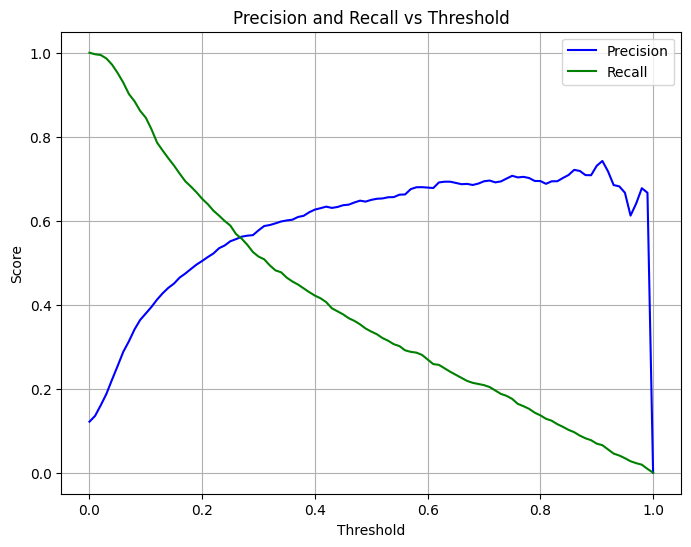

In [51]:
# Plot precision and recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Find the threshold where precision and recall intersect
precision_array = np.array(precisions)
recall_array = np.array(recalls)
intersection_idx = np.argwhere(np.isclose(precision_array, recall_array, atol=0.01)).flatten()

In [53]:
# Find the closest intersection threshold (if multiple, pick the first)
if len(intersection_idx) > 0:
    intersection_threshold = thresholds[intersection_idx[0]]
    print(f"Precision and Recall curves intersect at threshold: {intersection_threshold}")
else:
    print("No intersection found within the given thresholds.")

Precision and Recall curves intersect at threshold: 0.27


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [56]:
# Get predicted probabilities
y_scores = model.predict_proba(X_test)[:, 1]

c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [57]:
# Compute F1 score for thresholds from 0.0 to 1.0 with increment 0.01
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

In [58]:
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daiyaan\miniconda3\Lib\site-packages\sklearn\m

In [59]:
# Find the threshold with the maximum F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_scores[max_f1_index]

print(f'Max F1 score: {max_f1_value:.2f} at threshold: {max_f1_threshold:.2f}')

Max F1 score: 0.21 at threshold: 0.00


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [61]:
from sklearn.model_selection import KFold

In [62]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [63]:
# Store AUC scores
auc_scores = []

In [64]:
# Perform 5-fold CV
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val, y_val_probs)
    auc_scores.append(auc)

In [65]:
# Calculate standard deviation of AUC scores
std_dev_auc = np.std(auc_scores)

print(f'Standard deviation of AUC scores across folds: {std_dev_auc:.4f}')

Standard deviation of AUC scores across folds: 0.0043


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [66]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [67]:
# List of C values to try
C_values = [0.000001, 0.001, 1]

In [68]:
# Store results
results = []

In [69]:
# Iterate over C values
for C in C_values:
    auc_scores = []
    
    # Perform 5-fold CV
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Get predicted probabilities
        y_val_probs = model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_val, y_val_probs)
        auc_scores.append(auc)
    
    # Calculate mean and std of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Round to 3 decimal digits
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

In [70]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['C', 'Mean AUC', 'Std AUC'])

In [71]:
# Display results
print(results_df)

          C  Mean AUC  Std AUC
0  0.000001     0.705    0.011
1  0.001000     0.867    0.006
2  1.000000     0.904    0.004


In [72]:
# Find the best C based on mean score and tie-breaking criteria
best_result = results_df.loc[results_df['Mean AUC'].idxmax()]

In [73]:
# If there are ties, apply tie-breaking rules
best_c = best_result['C']
best_mean_auc = best_result['Mean AUC']
best_std_auc = best_result['Std AUC']

In [74]:
# Check for ties
tied_results = results_df[results_df['Mean AUC'] == best_mean_auc]

In [75]:
if len(tied_results) > 1:
    # Select the score with the lowest std
    tied_results = tied_results[tied_results['Std AUC'] == tied_results['Std AUC'].min()]

    if len(tied_results) > 1:
        # Select the smallest C
        best_c = tied_results['C'].min()

print(f'The best C is: {best_c} with mean AUC: {best_mean_auc} and std AUC: {best_std_auc}')

The best C is: 1.0 with mean AUC: 0.904 and std AUC: 0.004
